In [1]:
import h5py
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np
import healpy as hp
from astropy.cosmology import FlatLambdaCDM
from astropy import cosmology
from astropy import units as u


In [2]:
data = np.load("/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc1024_nc1024_size625_nsteps60_s302_10tiled/flat/analysis_eqsqclpdpm_zs0.5_s302.fits_002.npz")

In [3]:
ell = data["ell"]
nu = data["nu"]
results = data["data"]

In [12]:
cov = np.cov(results, rowvar=False)
corr = np.corrcoef(results, rowvar=False)

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


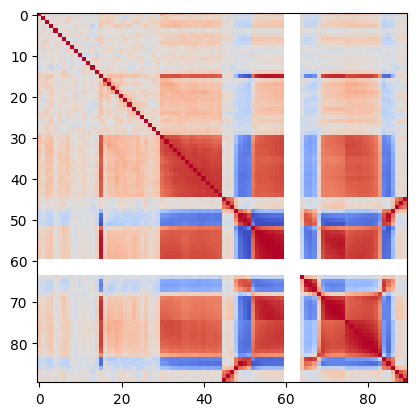

In [14]:
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

In [23]:

from src.utils.ConfigData import ConfigData, CatalogHandler

In [24]:
datadir ="/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc1024_nc1024_size625_nsteps60_s100_10tiled"
cath = CatalogHandler(datadir, "usmesh/", "HEALPIX/")

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [27]:
cath.cat.attrs["healpix.scheme"]

array(['R', 'I', 'N', 'G', ''], dtype='<U1')

In [2]:
data_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc1024_nc1024_size625_nsteps60_s100_10tiled/mass_sheets"
data_files = sorted(glob(f"{data_path}/*.npz"))

In [3]:
data = np.load(data_files[10])
print(data["chi1"], data["chi2"])

sample = data["delta"]
print(sample.min(), sample.max())

[4718.87752363] [4598.04228002]
-0.98333097 652.67


In [28]:
alms = hp.map2alm(hp.ud_grade(sample, 64))

In [33]:
np.array(alms, dtype=np.complex64)

array([-2.4432352e+00+0.j        ,  2.8154574e-04+0.j        ,
       -1.0558153e-04+0.j        , ..., -2.8439699e-04+0.00019179j,
       -4.6613644e-05-0.00032231j,  1.0310044e-04+0.00028823j],
      dtype=complex64)

In [ ]:
der1 = hp.alm2map_der

In [6]:
longitude = np.random.uniform(0, 360) * u.deg
latitude = np.random.uniform(-90, 90) * u.deg
rot_custom = hp.rotator.Rotator(rot=[longitude.to_value(u.deg), latitude.to_value(u.deg)], inv=False)

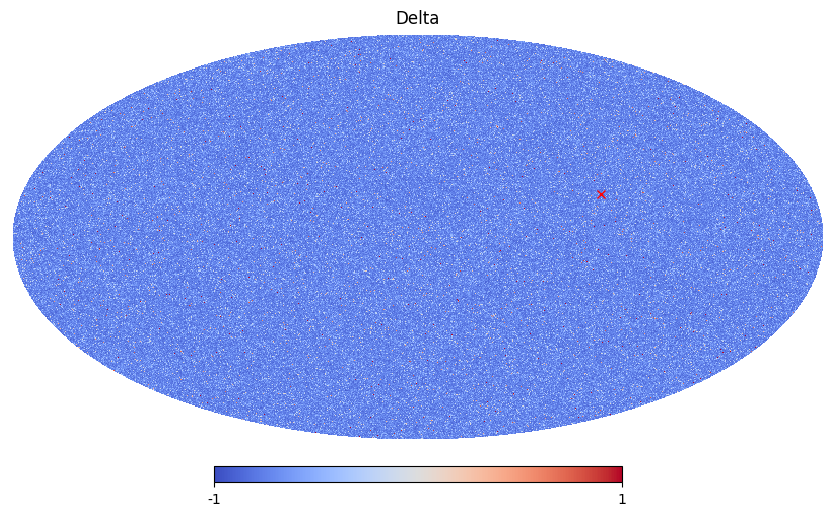

In [10]:
hp.mollview(sample, title="Delta", cmap="coolwarm", min=-1, max=1, nest=True)
hp.projplot(longitude.to_value(u.deg), latitude.to_value(u.deg), "rx")

In [11]:
sample_rot = rot_custom.rotate_map_alms(sample)

print(sample_rot.min(), sample_rot.max())

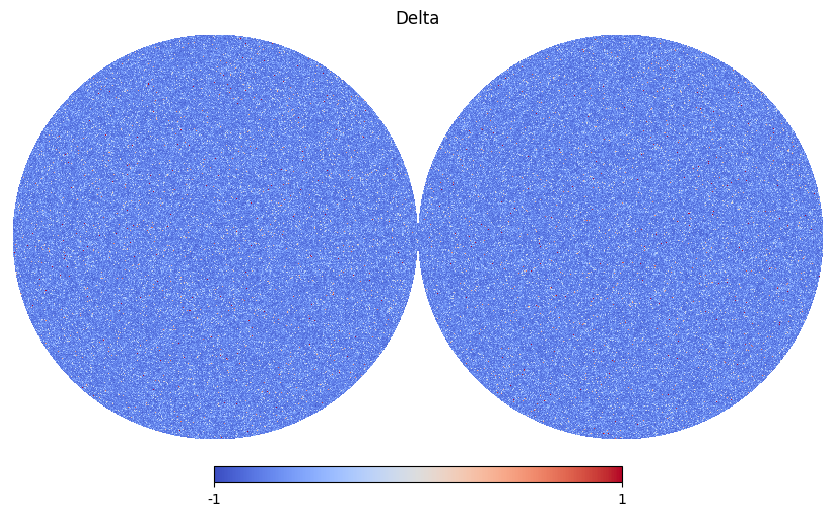

In [ ]:
hp.orthview(sample, title="Delta", cmap="coolwarm", min=-1, max=1)
hp.orthview(sample_rot, title="Delta Rotated", cmap="coolwarm", min=-1, max=1)

In [13]:

def set_cosmology(h=0.6774, om=0.309):
    """
    Set the cosmological parameters for the simulation
    if not using the default Planck15 cosmology.
    """
    global HUBBLE_CONSTANT, OMEGA_MATTER, cosmo
    HUBBLE_CONSTANT = h
    OMEGA_MATTER = om
    cosmo = FlatLambdaCDM(H0=HUBBLE_CONSTANT * 100, Om0=OMEGA_MATTER)

In [8]:
set_cosmology()

z = cosmology.z_at_value(cosmo.comoving_distance, 1000 * u.Mpc).value

In [12]:
cosmo.comoving_distance(z) / HUBBLE_CONSTANT

<Quantity 1476.23266199 Mpc>

In [172]:
# Path to the HDF5 file
fullsky_path_bigbox = sorted(glob('/lustre/work/akira.tokiwa/Projects/LensingSSC/results/analysis/kappa_bigbox_zs*_sl2_Euclid-LSST.h5'))
fullsky_path_tiled = sorted(glob('/lustre/work/akira.tokiwa/Projects/LensingSSC/results/analysis/kappa_tiled_zs*_sl2_Euclid-LSST.h5'))

In [180]:
def load_data_fullsky(file_path):
    with h5py.File(file_path, 'r') as f:
        clkk = f['clkk'][:]
        pdf = f['pdf'][:]
        peaks = f['peaks'][:] if 'peaks' in f else None
        minima = f['minima'][:] if 'minima' in f else None
        config_sim = f.attrs['config_sim']
        zs = f.attrs['zs']
        sl = f.attrs['sl']
        survey = f.attrs['survey']
        stddev = f.attrs['stddev']

        pdf
        peaks = np.histogram(peaks, bins=np.linspace(-4, 4, 16, endpoint=True) * stddev)[0] if peaks is not None else None
        minima = np.histogram(minima, bins=np.linspace(-4, 4, 16, endpoint=True) * stddev)[0] if minima is not None else None
        
    return clkk, pdf, peaks, minima, config_sim, zs, sl, survey, stddev

In [183]:
zs_list = [0.5, 1.0, 1.5, 2.0]
sl = 2
survey = 'Euclid-LSST'

paths_bigbox = sorted(glob('/lustre/work/akira.tokiwa/Projects/LensingSSC/results/analysis/flatsky_bigbox_zs*_sl10_Euclid-LSST.h5'))
paths_tiled = sorted(glob('/lustre/work/akira.tokiwa/Projects/LensingSSC/results/analysis/flatsky_tiled_zs*_sl10_Euclid-LSST.h5'))

In [184]:
def load_data(load_path, nbin=15, snr=True):
    with h5py.File(load_path, 'r') as f:
        # Load datasets
        results = f['data'][:]
        bins = f['bins'][:]
        centers = f['centers'][:]
        
        # Load metadata attributes
        config_sim = f.attrs['config_sim']
        zs = f.attrs['zs']
        sl = f.attrs['sl']
        survey = f.attrs['survey']
        std = f.attrs['stddev']
        lmin = f.attrs['lmin']
        lmax = f.attrs['lmax']
        xsize = f.attrs['xsize']
        patch_size = f.attrs['patch_size']

        # flip last nbin cols: minima
        results[:, -nbin:] = np.flip(results[:, -nbin:], axis=1)

        bins = bins[0]
        if snr: # replace last 3 nbin cols with np.linspace(-4, 4, nbin+1)
            bins[3*nbin:] = np.tile(np.linspace(-4, 4, nbin), 3)
        
    # Return the loaded data and metadata as a tuple
    return results, bins, centers, std, lmin, lmax, xsize, patch_size, config_sim, zs, sl, survey

In [185]:
def cal_stats(results):
    means = np.mean(results, axis=0)
    stds = np.std(results, axis=0)
    cov = np.cov(results.T)
    corr = np.corrcoef(results.T)
    diag = np.sqrt(np.diag(cov))
    
    return means, stds, cov, corr, diag

def bootstrap_sample(results, n=1000):
    n_samples = results.shape[0]
    indices = np.random.randint(0, n_samples, (n, n_samples))
    samples = results[indices]
    
    return samples

In [186]:
def set_ticks(ax, labels):
    tick_positions = [8 + 15 * i for i in range(len(labels))] 
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation=90, ha='right')

    # Add grid lines to separate statistics
    for i in range(1, len(labels)):
        ax.axhline(y=i * 15 - 0.5, color='black', linewidth=2)
        ax.axvline(x=i * 15 - 0.5, color='black', linewidth=2)

def plot_stats(axes, labels, color, bins, diag, linestyle='-', logscale=True, stddev=None):
    for i, label in enumerate(labels):
        ax = axes[i]
        im = ax.plot(bins[i*15:i*15+15], diag[i*15:i*15+15], linestyle=linestyle, color=color)
        if stddev is not None:
            ax.fill_between(bins[i*15:i*15+15], diag[i*15:i*15+15] - stddev[i*15:i*15+15], diag[i*15:i*15+15] + stddev[i*15:i*15+15], color=color, alpha=0.2)
        ax.set_title(label)
        if logscale:
            ax.set_yscale('log')
            ax.set_xscale('log') if i < 3 else None

def set_legends(colors, line_styles):
    # Custom legend handles
    legend_handles = []

    # Add handles for line styles
    for ls in line_styles:
        legend_handles.append(Line2D([0], [0], color='black', linestyle=line_styles[ls], label=ls))

    # Add handles for colors (redshifts)
    for zs in zs_list:
        legend_handles.append(Patch(color=colors[zs_list.index(zs)], label=f"zs={zs}"))

    return legend_handles

def setup_ratio(axes_ratio, labels, bins=None, nbin=15):
    axes_ratio[0].set_ylabel("Bigbox / Tiled")
    axes_ratio[3].set_ylabel("Bigbox / Tiled")

    for i in range(len(labels)):
        tmp_ax = axes_ratio[i]
        tmp_ax.set_ylim(0, 4)
        tmp_ax.hlines(1, np.min(bins[i*nbin:i*nbin+nbin]), np.max(bins[i*nbin:i*nbin+nbin]), linestyle='--', color='black')    

/var/tmp/pbs.269384.idark/ipykernel_276647/2253094071.py:69: RuntimeWarning: divide by zero encountered in true_divide
  plot_stats(axes_ratio4, labels, colors[zs_list.index(zs)], bins, diag2/diag, linestyle='-', logscale=False)
/var/tmp/pbs.269384.idark/ipykernel_276647/2253094071.py:69: RuntimeWarning: invalid value encountered in true_divide
  plot_stats(axes_ratio4, labels, colors[zs_list.index(zs)], bins, diag2/diag, linestyle='-', logscale=False)
/var/tmp/pbs.269384.idark/ipykernel_276647/2253094071.py:73: RuntimeWarning: divide by zero encountered in true_divide
  plot_stats(axes_ratio5, labels, colors[zs_list.index(zs)], bins, means2/means, linestyle='-', logscale=False)
/var/tmp/pbs.269384.idark/ipykernel_276647/2253094071.py:73: RuntimeWarning: invalid value encountered in true_divide
  plot_stats(axes_ratio5, labels, colors[zs_list.index(zs)], bins, means2/means, linestyle='-', logscale=False)


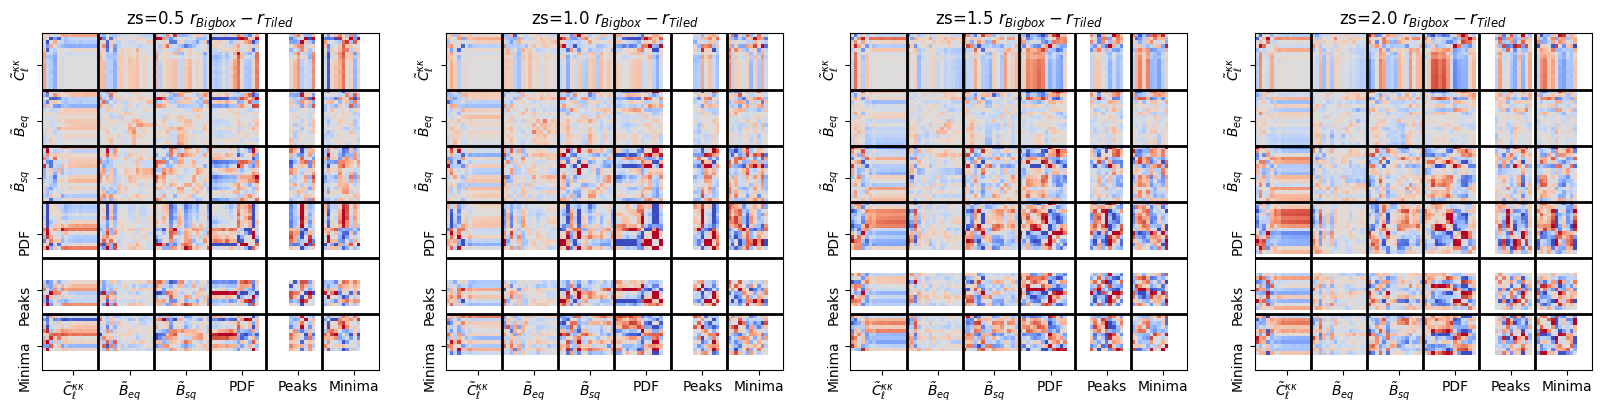

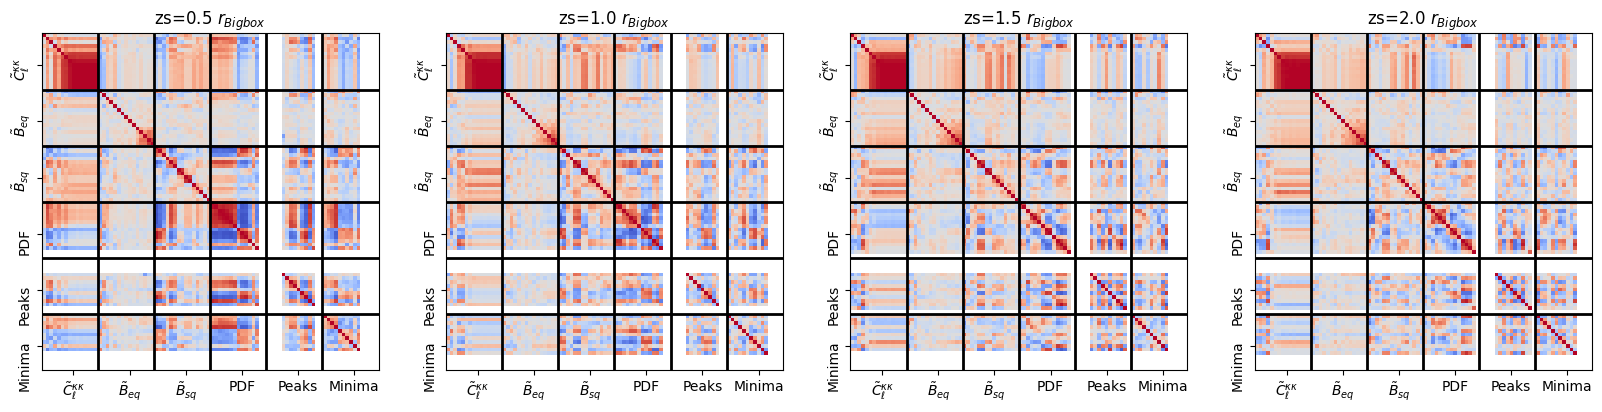

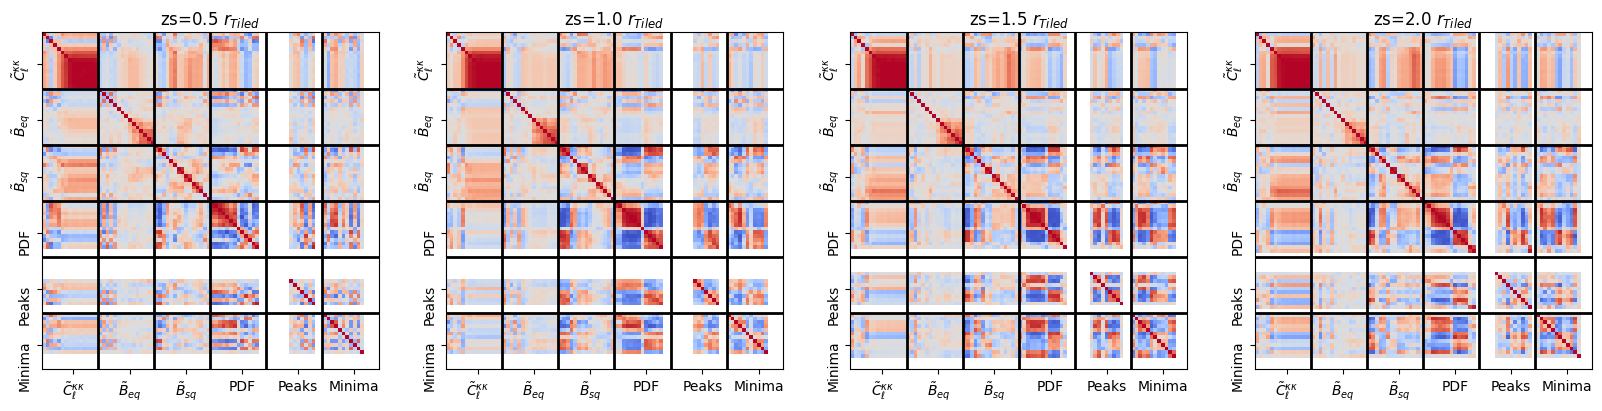

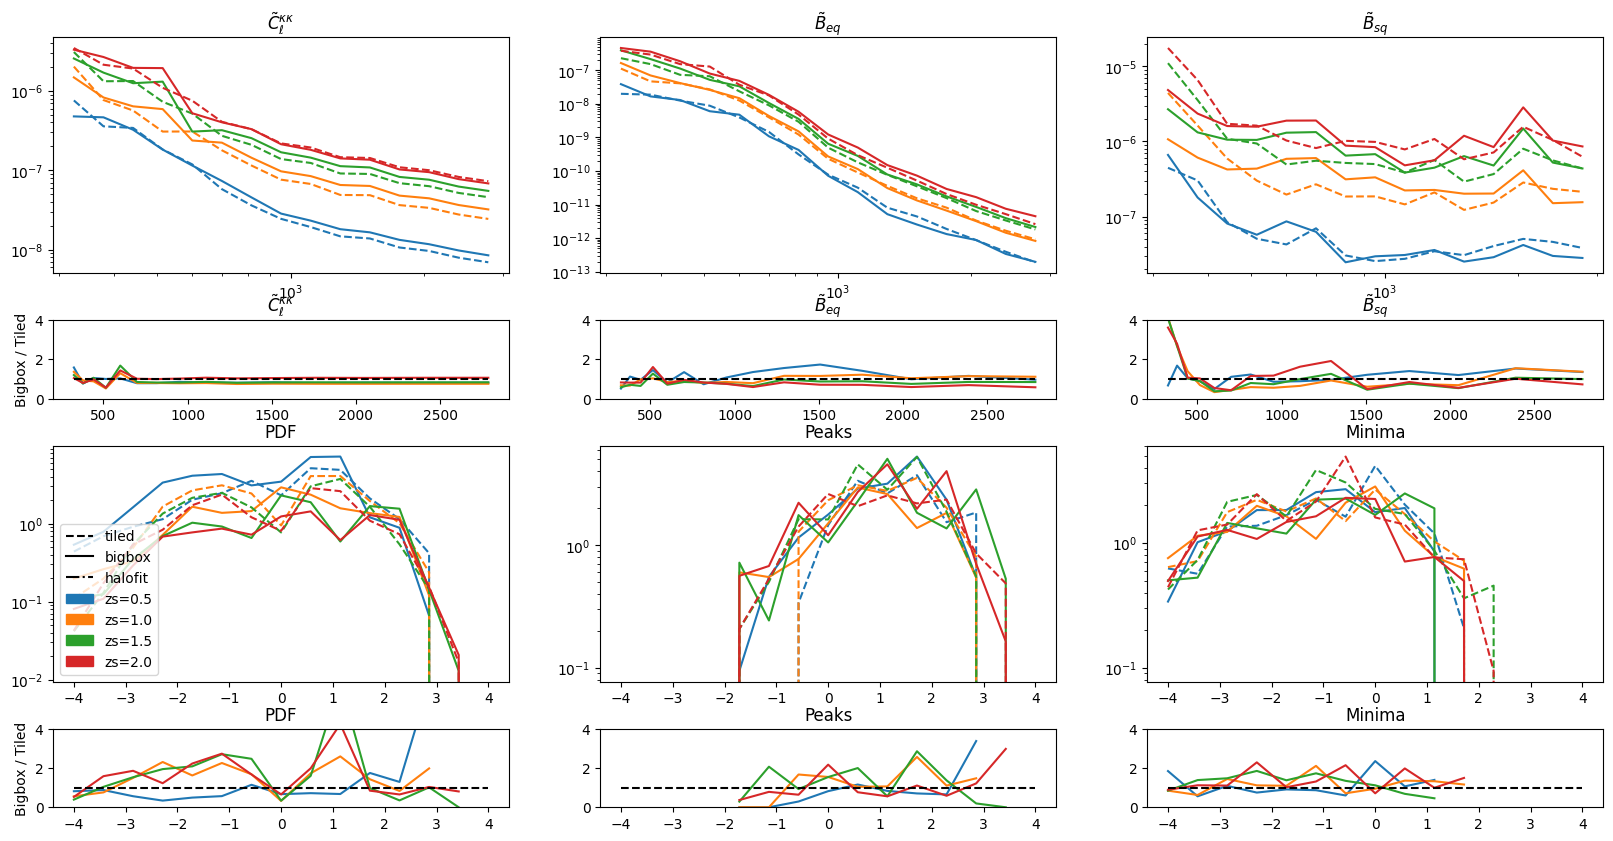

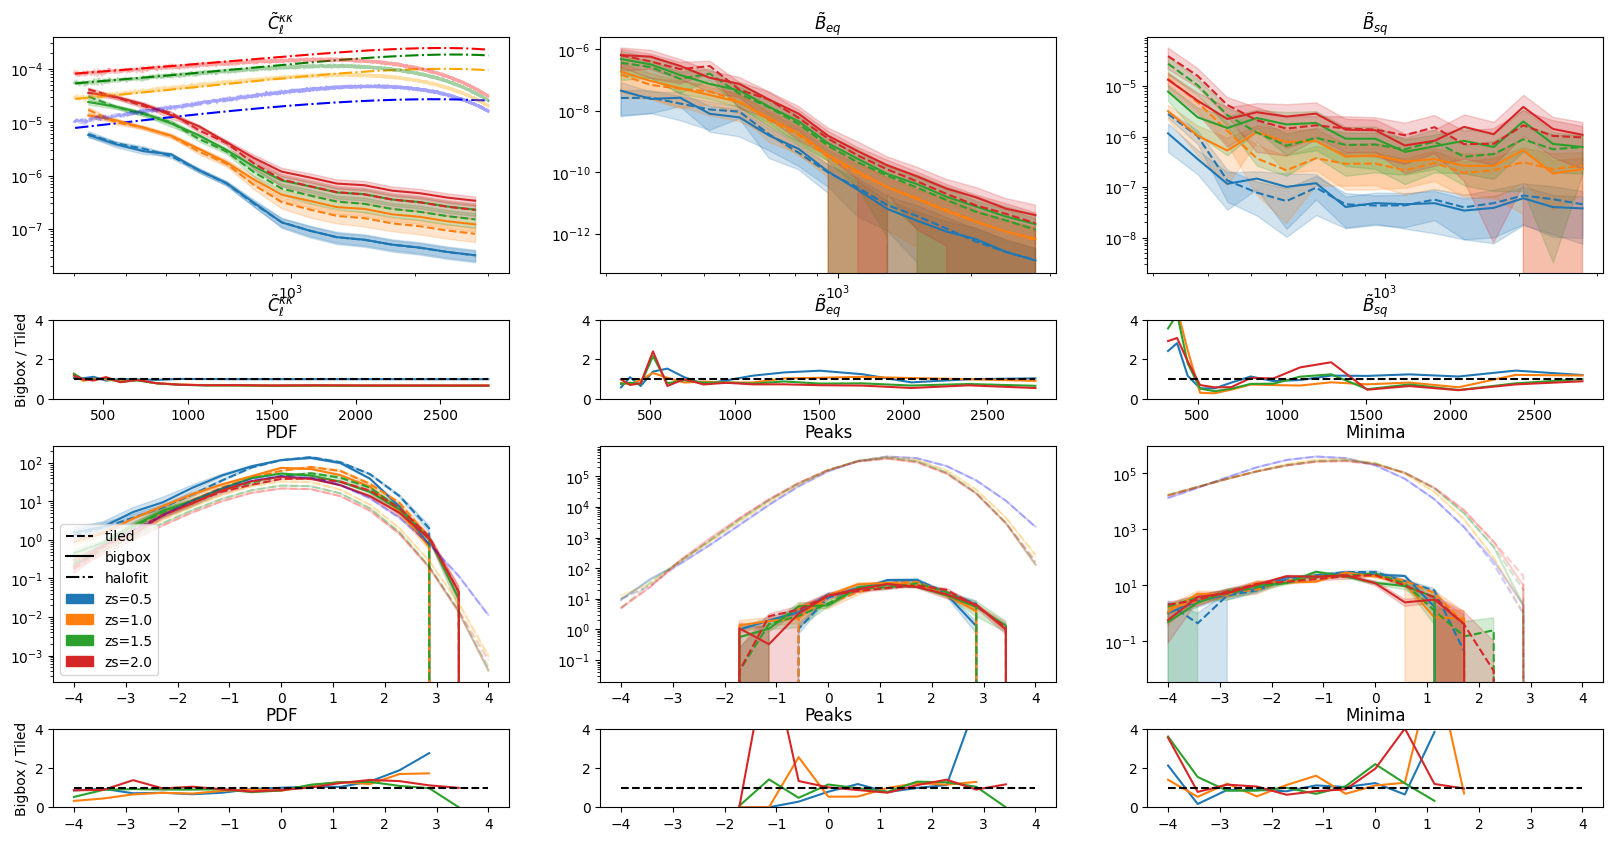

In [187]:
labels = [r'$\tilde{C}^{\kappa\kappa}_{\ell}$', #r'$C^{\kappa\kappa}_{\ell} \ell (\ell+1) / 2\pi$', 
          r'$\tilde{B}_{eq}$',#r'$B(\ell, \ell, \ell)  \ell^4 / (2\pi)^2 $', 
          r'$\tilde{B}_{sq}$',#r'$B(\ell, \ell, \sim0)  \ell^4 / (2\pi)^2$',
          "PDF",
          "Peaks",
          "Minima"
          ]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
colors2 = ['blue', 'orange', 'green', 'red']

# Define line styles
line_styles = {"tiled": "--", "bigbox": "-", "halofit": "-."}

# Set the legend handles
legend_handles = set_legends(colors, line_styles)


fig, ax = plt.subplots(1, len(zs_list), figsize=(20, 5))
fig2, ax2 = plt.subplots(1, len(zs_list), figsize=(20, 5))
fig3, ax3 = plt.subplots(1, len(zs_list), figsize=(20, 5))

# Create the figure and GridSpec layout
gs = GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.3)

fig4 = plt.figure(figsize=(20, 10))
axes4 = [fig4.add_subplot(gs[0, i]) for i in range(3)] + [fig4.add_subplot(gs[2, i]) for i in range(3)]
axes_ratio4 = [fig4.add_subplot(gs[1, i]) for i in range(3)] + [fig4.add_subplot(gs[3, i]) for i in range(3)]
axes4[3].legend(handles=legend_handles, loc='lower left')


fig5 = plt.figure(figsize=(20, 10))
axes5 = [fig5.add_subplot(gs[0, i]) for i in range(3)] + [fig5.add_subplot(gs[2, i]) for i in range(3)]
axes_ratio5 = [fig5.add_subplot(gs[1, i]) for i in range(3)] + [fig5.add_subplot(gs[3, i]) for i in range(3)]
axes5[3].legend(handles=legend_handles, loc='lower left')


for zs in zs_list:
    halofit = np.load(f"/lustre/work/akira.tokiwa/Projects/LensingSSC/results/halofit/kappa_zs{zs:.1f}_Clkk_ell_0_3000.npz")
    ell = halofit['ell'][300:3000]
    clkk = halofit['clkk'][300:3000]
    axes5[0].plot(ell, clkk * ell * (ell + 1) / 2 / np.pi, label=f'Halofit zs={zs}', color=colors2[zs_list.index(zs)], linestyle='-.')

for path, path2 in zip(paths_bigbox, paths_tiled):
    results, bins, centers, std, lmin, lmax, xsize, patch_size, config_sim, zs, sl, survey = load_data(path)
    means, stds, cov, corr, diag = cal_stats(results)

    results2, bins2, centers2, std2, lmin2, lmax2, xsize2, patch_size2, config_sim2, zs2, sl2, survey2 = load_data(path2)
    means2, stds2, cov2, corr2, diag2 = cal_stats(results2)

    # plot the correlation matrix difference
    corr_diff = corr2 - corr
    im = ax[zs_list.index(zs)].imshow(corr_diff, cmap='coolwarm', vmin=-1, vmax=1)
    ax[zs_list.index(zs)].set_title(f'zs={zs}'+r' $r_{Bigbox} - r_{Tiled}$')
    set_ticks(ax[zs_list.index(zs)], labels)

    # plot the correlation matrix of bigbox
    im2 = ax2[zs_list.index(zs)].imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    ax2[zs_list.index(zs)].set_title(f'zs={zs}'+r' $r_{Bigbox}$')
    set_ticks(ax2[zs_list.index(zs)], labels)

    # plot the correlation matrix of tiled
    im3 = ax3[zs_list.index(zs)].imshow(corr2, cmap='coolwarm', vmin=-1, vmax=1)
    ax3[zs_list.index(zs)].set_title(f'zs={zs}'+r' $r_{Tiled}$')
    set_ticks(ax3[zs_list.index(zs)], labels)

    plot_stats(axes4, labels, colors[zs_list.index(zs)], bins, diag, linestyle='-')
    plot_stats(axes4, labels, colors[zs_list.index(zs)], bins2, diag2, linestyle='--')
    plot_stats(axes_ratio4, labels, colors[zs_list.index(zs)], bins, diag2/diag, linestyle='-', logscale=False)

    plot_stats(axes5, labels, colors[zs_list.index(zs)], bins, means, linestyle='-', stddev=stds)
    plot_stats(axes5, labels, colors[zs_list.index(zs)], bins2, means2, linestyle='--', stddev=stds2)
    plot_stats(axes_ratio5, labels, colors[zs_list.index(zs)], bins, means2/means, linestyle='-', logscale=False)

setup_ratio(axes_ratio4, labels, bins)
setup_ratio(axes_ratio5, labels, bins)

for path, path2 in zip(fullsky_path_bigbox, fullsky_path_tiled):
    clkk, pdf, peaks, minima, config_sim, zs, sl, survey, stddev = load_data_fullsky(path)
    clkk2, pdf2, peaks2, minima2, config_sim2, zs2, sl2, survey2, stddev2 = load_data_fullsky(path2)

    ell = np.arange(300, 3001)
    axes5[0].plot(ell, clkk[-len(ell):] * ell * (ell + 1) / 2 / np.pi, label=f'fullsky zs={zs}', color=colors2[zs_list.index(zs)], linestyle=line_styles[config_sim], alpha=0.2)
    axes5[0].plot(ell, clkk2[-len(ell):] * ell * (ell + 1) / 2 / np.pi, label=f'fullsky zs={zs}', color=colors2[zs_list.index(zs)], linestyle=line_styles[config_sim2], alpha=0.2)

    axes5[3].plot(np.linspace(-4, 4, 15, endpoint=True), pdf, label=f'fullsky zs={zs}', color=colors2[zs_list.index(zs)], linestyle=line_styles[config_sim], alpha=0.2)
    axes5[3].plot(np.linspace(-4, 4, 15, endpoint=True), pdf2, label=f'fullsky zs={zs}', color=colors2[zs_list.index(zs)], linestyle=line_styles[config_sim2], alpha=0.2)

    axes5[4].plot(np.linspace(-4, 4, 15, endpoint=True), peaks, label=f'fullsky zs={zs}', color=colors2[zs_list.index(zs)], linestyle=line_styles[config_sim], alpha=0.2)
    axes5[4].plot(np.linspace(-4, 4, 15, endpoint=True), peaks2, label=f'fullsky zs={zs}', color=colors2[zs_list.index(zs)], linestyle=line_styles[config_sim2], alpha=0.2)

    axes5[5].plot(np.linspace(-4, 4, 15, endpoint=True), minima, label=f'fullsky zs={zs}', color=colors2[zs_list.index(zs)], linestyle=line_styles[config_sim], alpha=0.2)
    axes5[5].plot(np.linspace(-4, 4, 15, endpoint=True), minima2, label=f'fullsky zs={zs}', color=colors2[zs_list.index(zs)], linestyle=line_styles[config_sim2], alpha=0.2)

#plt.colorbar(im, ax=ax.ravel().tolist())
plt.show()

In [181]:
pdf.shape

(15,)

In [66]:
results, bins, centers, std, lmin, lmax, xsize, patch_size, config_sim, zs, sl, survey = load_data(path)

In [67]:
# bootstrap
n = 100
results_boot = np.zeros((n, results.shape[0], results.shape[1]))
for i in range(n):
    idx = np.random.choice(results.shape[0], results.shape[0], replace=True)
    results_boot[i] = results[idx]

# calculate diagonal covariance matrix
diags = []
for i in range(n):
    diags.append(np.sqrt(np.diag(np.cov(results_boot[i].T))))

diag_mean = np.mean(diags, axis=0)
diag_std = np.std(diags, axis=0)